# Loading data

In [2]:
using JuMP
using CSV
using DataFrames
using HiGHS

lines = CSV.read("/Users/alexanderklaus/Desktop/Masterthesis/Code/data/lines.csv", DataFrame)
#demand = CSV.read("/Users/alexanderklaus/Desktop/Masterthesis/Code/data/demand.csv", DataFrame)
#busses = CSV.read("/Users/alexanderklaus/Desktop/Masterthesis/Code/data/busses.csv", DataFrame)
bus_line_stops = CSV.read("/Users/alexanderklaus/Desktop/Masterthesis/Code/data/bus-lines.csv", DataFrame)

Row,bus_line_id,stop_ids,stop_x,stop_y
,Int64,Int64,Float64,Float64
1,1,1,2.2,36.8
2,1,2,4.4,40.1
3,1,3,12.5,42.7
4,1,4,20.2,44.0
5,2,1,40.9,48.2
6,2,2,46.2,40.7
7,2,3,56.6,38.2
8,3,1,44.6,15.2
9,3,2,52.0,20.4


In [3]:
bus_line_stops

Row,bus_line_id,stop_ids,stop_x,stop_y
,Int64,Int64,Float64,Float64
1,1,1,2.2,36.8
2,1,2,4.4,40.1
3,1,3,12.5,42.7
4,1,4,20.2,44.0
5,2,1,40.9,48.2
6,2,2,46.2,40.7
7,2,3,56.6,38.2
8,3,1,44.6,15.2
9,3,2,52.0,20.4


In [4]:
lines

Row,line_id,bus_line_id,start_time
,Int64,Int64,Float64
1,1,1,20.0
2,2,1,40.0
3,3,1,60.0
4,1,2,20.0
5,2,2,35.0
6,3,2,50.0
7,1,3,16.0
8,2,3,32.0
9,3,3,48.0


# Data understanding

## Adding the depot

In [63]:
depot=(bus_line_id=0,stop_ids=0,stop_x=30,stop_y=30)
insert!(bus_line_stops,1,depot)
depot=(line_id=0,bus_line_id=0, start_time=0)
insert!(lines,1,depot)

Row,line_id,bus_line_id,start_time
,Int64,Int64,Float64
1,0,0,0.0
2,1,1,20.0
3,2,1,40.0
4,3,1,60.0
5,1,2,20.0
6,2,2,35.0
7,3,2,50.0
8,1,3,16.0
9,2,3,32.0


## Looking at the stops

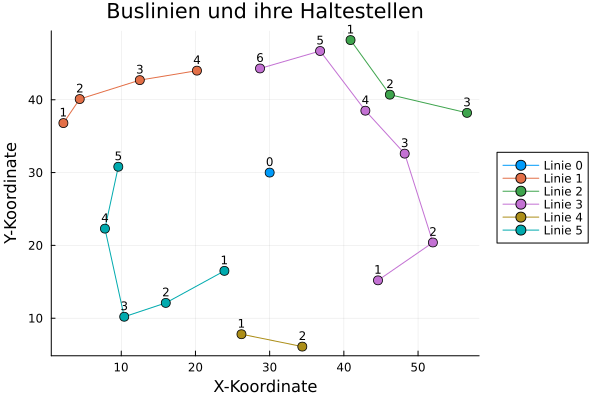

In [6]:
using Plots

# 1. Gruppiere nach bus_line_id
grouped_data = groupby(bus_line_stops, :bus_line_id)

# 2. Leere Plot-Canvas erstellen
plt = plot(title="Buslinien und ihre Haltestellen",
           xlabel="X-Koordinate", ylabel="Y-Koordinate",
           legend=:outerright)

# 3. Für jede Linie den Pfad zeichnen
for grp in grouped_data
    # Sortiere nach stop_ids, damit die Linien in Haltestellen-Reihenfolge gezeichnet werden
    sort!(grp, :stop_ids)
    
    # Zeichne die Linie mit Markern für die Haltestellen
    plot!(grp.stop_x, grp.stop_y,
          seriestype=:path,
          marker=:circle, markersize=5,
          label="Linie $(unique(grp.bus_line_id)[1])")
    
    # Beschrifte jede Haltestelle lesbar
    for i in 1:nrow(grp)
        annotate!(
            grp.stop_x[i], grp.stop_y[i] + 1.5,  # leicht über den Punkt verschieben
            text(string(grp.stop_ids[i]), 8, :black)  # größere Schrift, schwarze Farbe
        )
    end
end

# 4. Plot anzeigen
display(plt)


# Preprocessing

### Input settings

In [73]:
bus_velocity = 50 #in km/h

50

### Creating nodes for all stops, on every busline, for every tour

In [74]:
nodes = []

for r in eachrow(lines)
    for row in eachrow(bus_line_stops)
        if r.bus_line_id == row.bus_line_id
            start_time_temp=0.0
            if row.stop_ids == 1
                start_time_temp = r.start_time
            else
                # alle Stopps dieser Linie sortieren
                stops = sort(filter(r2 -> r2.bus_line_id == row.bus_line_id, eachrow(bus_line_stops)), by = r2 -> r2.stop_ids)
                
                # Travel time vom ersten Knoten bis aktuellen Knoten:
                total_distance = 0.0
                for k in 1:(row.stop_ids - 1)
                    x1, y1 = stops[k].stop_x, stops[k].stop_y
                    x2, y2 = stops[k+1].stop_x, stops[k+1].stop_y
                    total_distance += sqrt((x2 - x1)^2 + (y2 - y1)^2)
                end
                travel_time = (total_distance / bus_velocity) * 60  # Minuten

                # Startzeit = Startzeit erster Knoten + Travel Time
                start_time_temp = r.start_time + travel_time
            end
            push!(nodes, (
                bus_line_id = row.bus_line_id,
                line_id     = r.line_id,
                stop_id     = row.stop_ids,
                coord_x     = row.stop_x,
                coord_y     = row.stop_y,
                start_time  = start_time_temp
            ))
                
        end
    end
end

In [75]:
nodes

69-element Vector{Any}:
 (bus_line_id = 0, line_id = 0, stop_id = 0, coord_x = 30.0, coord_y = 30.0, start_time = 0.0)
 (bus_line_id = 0, line_id = 0, stop_id = 0, coord_x = 30.0, coord_y = 30.0, start_time = 0.0)
 (bus_line_id = 1, line_id = 1, stop_id = 1, coord_x = 2.2, coord_y = 36.8, start_time = 20.0)
 (bus_line_id = 1, line_id = 1, stop_id = 2, coord_x = 4.4, coord_y = 40.1, start_time = 24.75932768361247)
 (bus_line_id = 1, line_id = 1, stop_id = 3, coord_x = 12.5, coord_y = 42.7, start_time = 34.967794757566324)
 (bus_line_id = 1, line_id = 1, stop_id = 4, coord_x = 20.2, coord_y = 44.0, start_time = 44.338557800136556)
 (bus_line_id = 1, line_id = 2, stop_id = 1, coord_x = 2.2, coord_y = 36.8, start_time = 40.0)
 (bus_line_id = 1, line_id = 2, stop_id = 2, coord_x = 4.4, coord_y = 40.1, start_time = 44.75932768361247)
 (bus_line_id = 1, line_id = 2, stop_id = 3, coord_x = 12.5, coord_y = 42.7, start_time = 54.967794757566324)
 (bus_line_id = 1, line_id = 2, stop_id = 4, coord

### Creating connections

In [78]:
# Define a struct to hold the travel_time and end_time
struct Connection
    travel_time::Float64
    end_time::Float64
end

# Update the dictionary to use the struct as the value type
connections_dict = Dict()

for node1 in nodes
    for node2 in nodes
        if node1 != node2
            #skip if the nodes are the same
            origin_node = (node1.bus_line_id, node1.line_id, node1.stop_id)
            goal_node = (node2.bus_line_id, node2.line_id, node2.stop_id)
            
            if node1.bus_line_id == node2.bus_line_id
                # Nodes are on the same bus line
                stops = sort(filter(n -> n.bus_line_id == node1.bus_line_id, nodes), by = n -> n.stop_id)
                start_index = findfirst(n -> n.stop_id == node1.stop_id, stops)
                end_index = findfirst(n -> n.stop_id == node2.stop_id, stops)
                
                if start_index < end_index
                    total_distance = 0.0
                    for i in start_index:(end_index - 1)
                        x1, y1 = stops[i].coord_x, stops[i].coord_y
                        x2, y2 = stops[i + 1].coord_x, stops[i + 1].coord_y
                        total_distance += eucleadian_distance(x1, y1, x2, y2)
                    end
                    travel_time = (total_distance / bus_velocity) * 60 #travel_time in minutes
                    end_time = node1.start_time + travel_time
                    connections_dict[(origin_node, goal_node)] = Connection(travel_time, end_time)
                end
            else
                # Nodes are on different bus lines
                distance = eucleadian_distance(node1.coord_x, node1.coord_y, node2.coord_x, node2.coord_y)
                travel_time = (distance / bus_velocity) * 60 #travel_time in minutes
                end_time = node1.start_time + travel_time
                connections_dict[(origin_node, goal_node)] = Connection(travel_time, end_time)
            end
        end
    end
end

println("Connections dictionary:")
sort(collect(connections_dict), by = x -> x.first)

Connections dictionary:


4002-element Vector{Pair{Any, Any}}:
 ((0, 0, 0), (1, 1, 1)) => Connection(34.34348846579218, 34.34348846579218)
 ((0, 0, 0), (1, 1, 2)) => Connection(33.02442732281667, 33.02442732281667)
 ((0, 0, 0), (1, 1, 3)) => Connection(25.947207942281576, 25.947207942281576)
 ((0, 0, 0), (1, 1, 4)) => Connection(20.507013434432622, 20.507013434432622)
 ((0, 0, 0), (1, 2, 1)) => Connection(34.34348846579218, 34.34348846579218)
 ((0, 0, 0), (1, 2, 2)) => Connection(33.02442732281667, 33.02442732281667)
 ((0, 0, 0), (1, 2, 3)) => Connection(25.947207942281576, 25.947207942281576)
 ((0, 0, 0), (1, 2, 4)) => Connection(20.507013434432622, 20.507013434432622)
 ((0, 0, 0), (1, 3, 1)) => Connection(34.34348846579218, 34.34348846579218)
 ((0, 0, 0), (1, 3, 2)) => Connection(33.02442732281667, 33.02442732281667)
                        ⋮
 ((5, 4, 5), (3, 3, 6)) => Connection(28.067176559105476, 129.2922629521857)
 ((5, 4, 5), (4, 1, 1)) => Connection(34.03772025268437, 135.26280664576458)
 ((5, 4, 5), (4

In [79]:
connections_dict[((1,1,1),(1,1,2))].travel_time

4.7593276836124705

### Dictionary mit Stopp-IDs je Linie

In [8]:
line_stops_dict = Dict{Int, Vector{Int}}()

for row in eachrow(bus_line_stops)
    l = row.bus_line_id
    stop = row.stop_ids
    # Depot-Zeile überspringen
    if l == 0 && stop == 0
        continue
    end
    if haskey(line_stops_dict, l)
        push!(line_stops_dict[l], stop)
    else
        line_stops_dict[l] = [stop]
    end
end
println("Dictionary of lines with their respective stop-sequences:")
sort(line_stops_dict)

Dictionary of lines with their respective stop-sequences:


OrderedCollections.OrderedDict{Int64, Vector{Int64}} with 5 entries:
  1 => [1, 2, 3, 4]
  2 => [1, 2, 3]
  3 => [1, 2, 3, 4, 5, 6]
  4 => [1, 2]
  5 => [1, 2, 3, 4, 5]

### Distance Calculations

In [9]:
function eucleadian_distance(x1, y1, x2, y2)
    return sqrt((x1 - x2)^2 + (y1 - y2)^2)
end

eucleadian_distance (generic function with 1 method)

#### All distances as eucledian

In [10]:
distances_stops_dict=Dict()
for i in 1:length(bus_line_stops.stop_x)
    for j in i:length(bus_line_stops.stop_x)  
        #hier wird im Kopf der for-schleife von einer symmetrischen Matrix ausgegangen durch das " ... in i: ..."
        distance_temp =sqrt((bus_line_stops.stop_x[j]-bus_line_stops.stop_x[i])^2+(bus_line_stops.stop_y[j]-bus_line_stops.stop_y[i])^2)
        key=(bus_line_stops.bus_line_id[i],bus_line_stops.stop_ids[i]),(bus_line_stops.bus_line_id[j],bus_line_stops.stop_ids[j])
        distances_stops_dict[key]=distance_temp
        println(key)
    end
end
sort(collect(distances_stops_dict))

((0, 0), (0, 0))
((0, 0), (1, 1))
((0, 0), (1, 2))
((0, 0), (1, 3))
((0, 0), (1, 4))
((0, 0), (2, 1))
((0, 0), (2, 2))
((0, 0), (2, 3))
((0, 0), (3, 1))
((0, 0), (3, 2))
((0, 0), (3, 3))
((0, 0), (3, 4))
((0, 0), (3, 5))
((0, 0), (3, 6))
((0, 0), (4, 1))
((0, 0), (4, 2))
((0, 0), (5, 1))
((0, 0), (5, 2))
((0, 0), (5, 3))
((0, 0), (5, 4))
((0, 0), (5, 5))
((1, 1), (1, 1))
((1, 1), (1, 2))
((1, 1), (1, 3))
((1, 1), (1, 4))
((1, 1), (2, 1))
((1, 1), (2, 2))
((1, 1), (2, 3))
((1, 1), (3, 1))
((1, 1), (3, 2))
((1, 1), (3, 3))
((1, 1), (3, 4))
((1, 1), (3, 5))
((1, 1), (3, 6))
((1, 1), (4, 1))
((1, 1), (4, 2))
((1, 1), (5, 1))
((1, 1), (5, 2))
((1, 1), (5, 3))
((1, 1), (5, 4))
((1, 1), (5, 5))
((1, 2), (1, 2))
((1, 2), (1, 3))
((1, 2), (1, 4))
((1, 2), (2, 1))
((1, 2), (2, 2))
((1, 2), (2, 3))
((1, 2), (3, 1))
((1, 2), (3, 2))
((1, 2), (3, 3))
((1, 2), (3, 4))
((1, 2), (3, 5))
((1, 2), (3, 6))
((1, 2), (4, 1))
((1, 2), (4, 2))
((1, 2), (5, 1))
((1, 2), (5, 2))
((1, 2), (5, 3))
((1, 2), (5, 4

231-element Vector{Pair{Any, Any}}:
 ((0, 0), (0, 0)) => 0.0
 ((0, 0), (1, 1)) => 28.619573721493477
 ((0, 0), (1, 2)) => 27.520356102347225
 ((0, 0), (1, 3)) => 21.622673285234647
 ((0, 0), (1, 4)) => 17.089177862027185
 ((0, 0), (2, 1)) => 21.2143819141638
 ((0, 0), (2, 2)) => 19.414685163555966
 ((0, 0), (2, 3)) => 27.83522947633089
 ((0, 0), (3, 1)) => 20.78942038634074
 ((0, 0), (3, 2)) => 24.003333101884
                  ⋮
 ((5, 2), (5, 3)) => 5.913543776789007
 ((5, 2), (5, 4)) => 13.08739851918631
 ((5, 2), (5, 5)) => 19.764867821465444
 ((5, 3), (5, 3)) => 0.0
 ((5, 3), (5, 4)) => 12.376186811776881
 ((5, 3), (5, 5)) => 20.615528128088304
 ((5, 4), (5, 4)) => 0.0
 ((5, 4), (5, 5)) => 8.688498144098322
 ((5, 5), (5, 5)) => 0.0

#### All distances calculated as eucledean except: start to finish are from same line, then total distance = sum of segments

In [11]:
distances_stops_dict_2 = Dict{Tuple{Tuple{Int, Int}, Tuple{Int, Int}}, Float64}()

for i in 1:length(bus_line_stops.stop_x)
    for j in i:length(bus_line_stops.stop_x)
        a = (bus_line_stops.bus_line_id[i], bus_line_stops.stop_ids[i])
        b = (bus_line_stops.bus_line_id[j], bus_line_stops.stop_ids[j])
        c = b[1]  # Linien-ID

        # Bedingung: erste zur letzten Haltestelle derselben Linie
        if a[2] == 1 && a[1] == b[1] && b[2] == last(line_stops_dict[c])
            # hole alle Stopps dieser Linie und sortiere sie nach Reihenfolge
            stops = sort(filter(row -> row.bus_line_id == c, eachrow(bus_line_stops)),by = r -> r.stop_ids)

            # summme der Teilstrecken
            total_length = 0.0
            for k in 1:(length(stops)-1)
                x1, y1 = stops[k].stop_x, stops[k].stop_y
                x2, y2 = stops[k+1].stop_x, stops[k+1].stop_y
                total_length += sqrt((x2 - x1)^2 + (y2 - y1)^2)
            end
            key = (a, b)
            distances_stops_dict_2[key] = total_length
        else 
            distance_temp = sqrt((bus_line_stops.stop_x[j]-bus_line_stops.stop_x[i])^2+(bus_line_stops.stop_y[j]-bus_line_stops.stop_y[i])^2)
            key = (a, b)
            distances_stops_dict_2[key]=distance_temp
        end
    end
end
sort(collect(distances_stops_dict_2))


231-element Vector{Pair{Tuple{Tuple{Int64, Int64}, Tuple{Int64, Int64}}, Float64}}:
 ((0, 0), (0, 0)) => 0.0
 ((0, 0), (1, 1)) => 28.619573721493477
 ((0, 0), (1, 2)) => 27.520356102347225
 ((0, 0), (1, 3)) => 21.622673285234647
 ((0, 0), (1, 4)) => 17.089177862027185
 ((0, 0), (2, 1)) => 21.2143819141638
 ((0, 0), (2, 2)) => 19.414685163555966
 ((0, 0), (2, 3)) => 27.83522947633089
 ((0, 0), (3, 1)) => 20.78942038634074
 ((0, 0), (3, 2)) => 24.003333101884
                  ⋮
 ((5, 2), (5, 3)) => 5.913543776789007
 ((5, 2), (5, 4)) => 13.08739851918631
 ((5, 2), (5, 5)) => 19.764867821465444
 ((5, 3), (5, 3)) => 0.0
 ((5, 3), (5, 4)) => 12.376186811776881
 ((5, 3), (5, 5)) => 20.615528128088304
 ((5, 4), (5, 4)) => 0.0
 ((5, 4), (5, 5)) => 8.688498144098322
 ((5, 5), (5, 5)) => 0.0

### Total length of every line

In [12]:
# Dictionary zur Speicherung der Linienlängen
line_lengths_dict = Dict{Int, Float64}()

# Alle eindeutigen Linien ermitteln
unique_lines = unique(bus_line_stops.bus_line_id)

for line in unique_lines
    if line == 0
        continue
    end

    # Filtere Stopps dieser Linie und sortiere nach stop_ids
    stops = sort(filter(row -> row.bus_line_id == line, eachrow(bus_line_stops)), by = r -> r.stop_ids)
    line_length = 0.0
    for i in 1:(length(stops)-1)
        x1, y1 = stops[i].stop_x, stops[i].stop_y
        x2, y2 = stops[i+1].stop_x, stops[i+1].stop_y
        line_length += sqrt((x2 - x1)^2 + (y2 - y1)^2) # in Kilometern
    end

    line_lengths_dict[line] = line_length
end
println("Total line lengths:")
sort(collect(line_lengths_dict))

Total line lengths:


5-element Vector{Pair{Int64, Float64}}:
 1 => 20.282131500113792
 2 => 19.879942208111522
 3 => 48.421548524989944
 4 => 8.374365647617735
 5 => 36.02090532756685

### Time Calculations

#### Input settings

In [13]:
bus_velocity= 200 #in km/h

200

#### Calculations

##### Dauer zwischen allen Knoten: durations_each_node_dict

In [14]:
#############
#Berechnung der Dauer von jedem Knoten zu jedem anderen Knoten
#############
durations_each_connection_dict=Dict()
# Neues Dictionary für die Reisezeiten
for (key, dist) in distances_stops_dict_2
    # Fahrtzeit in Minuten berechnen
    time_min = (dist / bus_velocity * 60)
    durations_each_connection_dict[key] = time_min
end
println("\n\nDictionary of durations from every node to every node:")
sort(collect(durations_each_connection_dict))



Dictionary of durations from every node to every node:


231-element Vector{Pair{Any, Any}}:
 ((0, 0), (0, 0)) => 0.0
 ((0, 0), (1, 1)) => 8.585872116448044
 ((0, 0), (1, 2)) => 8.256106830704168
 ((0, 0), (1, 3)) => 6.486801985570394
 ((0, 0), (1, 4)) => 5.1267533586081555
 ((0, 0), (2, 1)) => 6.36431457424914
 ((0, 0), (2, 2)) => 5.82440554906679
 ((0, 0), (2, 3)) => 8.350568842899268
 ((0, 0), (3, 1)) => 6.236826115902222
 ((0, 0), (3, 2)) => 7.2009999305652
                  ⋮
 ((5, 2), (5, 3)) => 1.774063133036702
 ((5, 2), (5, 4)) => 3.9262195557558934
 ((5, 2), (5, 5)) => 5.929460346439633
 ((5, 3), (5, 3)) => 0.0
 ((5, 3), (5, 4)) => 3.712856043533064
 ((5, 3), (5, 5)) => 6.184658438426491
 ((5, 4), (5, 4)) => 0.0
 ((5, 4), (5, 5)) => 2.606549443229497
 ((5, 5), (5, 5)) => 0.0

##### Dauer jeder Linie: duration_line_dict

In [15]:
#######
#Filtern der Dauer jeder Linie
#######
duration_line_dict = Dict(k => v for (k, v) in durations_each_connection_dict if k[1][1] == k[2][1] && k[1][2] == 1 && k[2][2]==last(line_stops_dict[k[1][1]]))
sort(collect(duration_line_dict))

5-element Vector{Pair{Tuple{Tuple{Int64, Int64}, Tuple{Int64, Int64}}, Float64}}:
 ((1, 1), (1, 4)) => 6.084639450034138
 ((2, 1), (2, 3)) => 5.963982662433457
 ((3, 1), (3, 6)) => 14.526464557496983
 ((4, 1), (4, 2)) => 2.5123096942853205
 ((5, 1), (5, 5)) => 10.806271598270055

##### Dauer Depot <-> erster Stop: duration_depot_firststop_dict

In [16]:
########
#Filtern der Dauer von Depot zu jeder ersten Haltestelle
########
duration_depot_firststop_dict= Dict(k => v for (k, v) in durations_each_connection_dict if k[1] == (0,0) && k[2][2] ==1)
sort(collect(duration_depot_firststop_dict))

5-element Vector{Pair{Tuple{Tuple{Int64, Int64}, Tuple{Int64, Int64}}, Float64}}:
 ((0, 0), (1, 1)) => 8.585872116448044
 ((0, 0), (2, 1)) => 6.36431457424914
 ((0, 0), (3, 1)) => 6.236826115902222
 ((0, 0), (4, 1)) => 6.7568631775403
 ((0, 0), (5, 1)) => 4.444254718172666

##### Dauer last_stop <-> Depot: duration_laststop_depot_dict

In [17]:
########
#Filtern der Dauer von jeder letzten Haltestelle zum Depot
########
duration_laststop_depot_dict=Dict(k => v for (k, v) in durations_each_connection_dict if k[2][1]!=0 && k[1]==(0,0) && k[2][2] == last(line_stops_dict[k[2][1]]))
sort(collect(duration_laststop_depot_dict))

5-element Vector{Pair{Tuple{Tuple{Int64, Int64}, Tuple{Int64, Int64}}, Float64}}:
 ((0, 0), (1, 4)) => 5.1267533586081555
 ((0, 0), (2, 3)) => 8.350568842899268
 ((0, 0), (3, 6)) => 4.307690796703031
 ((0, 0), (4, 2)) => 7.290493810435613
 ((0, 0), (5, 5)) => 6.124704074483926

##### Dauer end_of_line <-> start of line: durations_each_end_to_start_dict

In [18]:
########
#Filtern von der Dauern vom Ende einer Linie zum Beginn aller anderen Linien in der smmyterischen Matrix
dict_temp_1=Dict((from,to) => v for ((from,to), v) in durations_each_connection_dict if from[1]!=0 && from[1]!=to[1] && from[2] == last(line_stops_dict[from[1]]) && to[2] == first(line_stops_dict[to[1]]))

################
#dieser Part verwendet dieselbe Distanz zwischen zwei Knoten für beide Richtungen (Hinweg = Rückweg)
#################
dict_temp_2=Dict()
for i in keys(durations_each_connection_dict)
    to, from = i  #hiermit werden auch die Verbindungen berücksichtigt, die keinen eigenen tuple haben, deren Dauer aber trotzdem in der Matrix stehen
    if to[1] == 0
        continue
    end
    if from[1]!=to[1] && from[2] == last(line_stops_dict[from[1]]) && to[2] == first(line_stops_dict[to[1]])
        i_temp=(from, to)
        dict_temp_2[i_temp]=durations_each_connection_dict[(to,from)]        
    end
end
durations_each_end_to_start_dict = merge(dict_temp_1, dict_temp_2)
sort(collect(durations_each_end_to_start_dict))


20-element Vector{Pair{Any, Any}}:
 ((1, 4), (2, 1)) => 6.336536909069496
 ((1, 4), (3, 1)) => 11.323956905605039
 ((1, 4), (4, 1)) => 11.008160609293453
 ((1, 4), (5, 1)) => 8.324337811501886
 ((2, 3), (1, 1)) => 16.325403517218188
 ((2, 3), (3, 1)) => 7.78267306264371
 ((2, 3), (4, 1)) => 12.897627688842627
 ((2, 3), (5, 1)) => 11.773538125814177
 ((3, 6), (1, 1)) => 8.262263612352246
 ((3, 6), (2, 1)) => 3.8424601494355146
 ((3, 6), (4, 1)) => 10.97565487795603
 ((3, 6), (5, 1)) => 8.463403570668245
 ((4, 2), (1, 1)) => 13.346898516134749
 ((4, 2), (2, 1)) => 12.779647882473133
 ((4, 2), (3, 1)) => 4.100792606314053
 ((4, 2), (5, 1)) => 4.433610267039719
 ((5, 5), (1, 1)) => 2.858041287315492
 ((5, 5), (2, 1)) => 10.743393318686604
 ((5, 5), (3, 1)) => 11.495755738532374
 ((5, 5), (4, 1)) => 8.509430063171093

### Populating set A

#### A_temp

In [19]:
function get_connections_which_fulfill_time_constraint(lines, line_stops_dict, durations_each_end_to_start_dict, duration_depot_firststop_dict, duration_line_dict,A_set)
    for i in sort(collect(keys(durations_each_end_to_start_dict)))
        from, to = i
        a, b = from
        c, d = to
        # Depot-Zeile überspringen
        if from[2]==0
            continue
        end
        #check only for the connections between the lines
        if from[2] == last(line_stops_dict[from[1]]) && to[2] == 1 && from[1]!=to[1]#if connection ist zwischen ende von Linie a und anfang von Linie b
            #display("Calculating for connection $i:")
            possible_origin_lines = filter(row -> row.bus_line_id == from[1], eachrow(lines))
            possible_goal_lines = filter(row -> row.bus_line_id == to[1], eachrow(lines))
            for row_i in possible_origin_lines
                if i in A_set
                    #display("Skipped, connection $i already in A_temp.")
                    break
                else
                    bl1_temp=row_i.bus_line_id
                    l1_id_temp=row_i.line_id
                    t_start_first_line=row_i.start_time
                    #display("Checking for tour $bl1_temp-$l1_id_temp with start time $t_start_first_line")
                    t_depot_firststop = duration_depot_firststop_dict[((0,0),(from[1],1))] 

                    #check only for tours which can actually be started
                    if t_depot_firststop < t_start_first_line
                        #display("Tour $bl1_temp-$l1_id_temp can be started!")
                        for row_j in possible_goal_lines
                            bl2_temp=row_j.bus_line_id
                            l2_id_temp=row_j.line_id
                            #t_end_first_line = t_start_first_line + duration_line_dict[((from[1],first(line_stops_dict[from[1]])),((from[1],last(line_stops_dict[from[1]]))))]
                            t_end_first_line_without_depot_firststop = duration_line_dict[((from[1],first(line_stops_dict[from[1]])),((from[1],last(line_stops_dict[from[1]]))))]
                            t_between_lines= durations_each_end_to_start_dict[i]
                            t_start_second_line=row_j.start_time
                            #add only those connections bewteen lines if the time-constraint holds for at least on connections of tours
                            #display("Checking if connection from tour $bl1_temp-$l1_id_temp to tour $bl2_temp-$l2_id_temp can be upheld")
                            if t_end_first_line_without_depot_firststop + t_between_lines <= t_start_second_line
                                if !(i in A_set)
                                    push!(A_set, i)
                                    #display("Added connection $i, because end of tour $bl1_temp-$l1_id_temp is $t_end_first_line_without_depot_firststop and start of tour $bl2_temp-$l2_id_temp is $t_start_second_line.")
                                else
                                    #display("Skipped, connection already in A_temp.")
                                end
                            else
                                #display("Time-constraint not fulfilled, skipping...")
                            end
                        end
                    else
                        #display("Tour $bl1_temp-$l1_id_temp cannot be started in time, skipping...")
                        continue
                    end 
                end
                if i in A_set
                    break
                end
            end
        end
    end
end

get_connections_which_fulfill_time_constraint (generic function with 1 method)

#### Completing A_set

In [20]:
A_set = []
for i in keys(distances_stops_dict_2)
    from, to = i
    # Depot-Zeile überspringen
    if to[2]==0
        continue
    end
    #Connection Depot <-> erste Haltestelle wird mit aufgenommen
    if from == (0, 0) && to[2] == 1
        push!(A_set, i)
    #=elseif b== (0, 0) && a[2] == 1            für den Fall einer unsymmetrischen Matrix
        push!(A_set, i)
    =#
    #Connection Depot <-> letzte Haltestelle wird mit aufgenommen
    end
    if from == (0, 0) && to[2]==last(line_stops_dict[to[1]])
        i_temp=(to,from)
        push!(A_set, i_temp)
    #=elseif to == (0, 0) && from[2] == last(line_stops_dict[c])     für den Fall einer unsymmetrischen Matrix
        push!(A_set, i)
    =#
    #Connection erste Haltestelle <-> letzte Haltestelle derselben Linie wird mit aufgenommen
    end
    if from[2] == 1 && from[1] == to[1] && to[2] == last(line_stops_dict[to[1]])
        push!(A_set, i)
    end
end



In [21]:
#Connection zwischen den Linien unter der Bedingung "t_end_of_first_line + t_between_lines <= t_start_time_second_line"
get_connections_which_fulfill_time_constraint(lines, line_stops_dict, durations_each_end_to_start_dict, duration_depot_firststop_dict, duration_line_dict,A_set)
sort(collect(A_set))

35-element Vector{Any}:
 ((0, 0), (1, 1))
 ((0, 0), (2, 1))
 ((0, 0), (3, 1))
 ((0, 0), (4, 1))
 ((0, 0), (5, 1))
 ((1, 1), (1, 4))
 ((1, 4), (0, 0))
 ((1, 4), (2, 1))
 ((1, 4), (3, 1))
 ((1, 4), (4, 1))
 ⋮
 ((4, 2), (2, 1))
 ((4, 2), (3, 1))
 ((4, 2), (5, 1))
 ((5, 1), (5, 5))
 ((5, 5), (0, 0))
 ((5, 5), (1, 1))
 ((5, 5), (2, 1))
 ((5, 5), (3, 1))
 ((5, 5), (4, 1))

### Populating set V

In [22]:
V_Set = Set{Tuple{Int,Int}}()
push!(V_Set, (0, 0))  # Depot

for l in keys(line_stops_dict)
    first_stop = (l, first(line_stops_dict[l]))
    last_stop = (l, last(line_stops_dict[l]))
    push!(V_Set, first_stop)
    push!(V_Set, last_stop)
end

V_Set = sort(collect(V_Set))

11-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (1, 1)
 (1, 4)
 (2, 1)
 (2, 3)
 (3, 1)
 (3, 6)
 (4, 1)
 (4, 2)
 (5, 1)
 (5, 5)

# Model definition

## Initialize model instance

In [23]:
model= Model(HiGHS.Optimizer)

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

## Initialize variables

In [24]:
@variable(model, x[(i,j) in A_set], Bin)

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, Any[((0, 0), (5, 1)), ((1, 1), (1, 4)), ((1, 4), (0, 0)), ((0, 0), (2, 1)), ((0, 0), (3, 1)), ((3, 1), (3, 6)), ((4, 2), (0, 0)), ((0, 0), (1, 1)), ((5, 1), (5, 5)), ((2, 3), (0, 0))  …  ((3, 6), (4, 1)), ((3, 6), (5, 1)), ((4, 2), (1, 1)), ((4, 2), (2, 1)), ((4, 2), (3, 1)), ((4, 2), (5, 1)), ((5, 5), (1, 1)), ((5, 5), (2, 1)), ((5, 5), (3, 1)), ((5, 5), (4, 1))]
And data, a 35-element Vector{VariableRef}:
 x[((0, 0), (5, 1))]
 x[((1, 1), (1, 4))]
 x[((1, 4), (0, 0))]
 x[((0, 0), (2, 1))]
 x[((0, 0), (3, 1))]
 x[((3, 1), (3, 6))]
 x[((4, 2), (0, 0))]
 x[((0, 0), (1, 1))]
 x[((5, 1), (5, 5))]
 x[((2, 3), (0, 0))]
 ⋮
 x[((3, 6), (5, 1))]
 x[((4, 2), (1, 1))]
 x[((4, 2), (2, 1))]
 x[((4, 2), (3, 1))]
 x[((4, 2), (5, 1))]
 x[((5, 5), (1, 1))]
 x[((5, 5), (2, 1))]
 x[((5, 5), (3, 1))]
 x[((5, 5), (4, 1))]

## Objective function

In [25]:
@objective(model, Min, sum(x[(i,j)] for (i,j) in A_set if i == (0,0)))

x[((0, 0), (5, 1))] + x[((0, 0), (2, 1))] + x[((0, 0), (3, 1))] + x[((0, 0), (1, 1))] + x[((0, 0), (4, 1))]

## Initialize constraints

### Flusserhaltung

In [26]:
#=m = length(keys(line_stops_dict))
println(m)
@variable(model, 0 <= f[(i,j) in A_set] <= m)
@constraint(model, [(i,j) in A_set], f[(i,j)] <= m * x[(i,j)])

# Flow starts at depot
@constraint(model, sum(f[(i,j)] for (i,j) in A_set if i == (0,0)) == m)

# Flow conservation for all other nodes
@constraint(model, [node in V_Set; node != (0,0)],
    sum(f[(i,j)] for (i,j) in A_set if j == node)
  - sum(f[(i,j)] for (i,j) in A_set if i == node)
  == 1
)
=#


@constraint(model, 
    flow_conservation[node in V_Set],
    sum(x[(i,j)] for (i,j) in A_set if j == node) - 
    sum(x[(i,j)] for (i,j) in A_set if i == node) == 0
)


1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [(0, 0), (1, 1), (1, 4), (2, 1), (2, 3), (3, 1), (3, 6), (4, 1), (4, 2), (5, 1), (5, 5)]
And data, a 11-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 flow_conservation[(0, 0)] : -x[((0, 0), (5, 1))] + x[((1, 4), (0, 0))] - x[((0, 0), (2, 1))] - x[((0, 0), (3, 1))] + x[((4, 2), (0, 0))] - x[((0, 0), (1, 1))] + x[((2, 3), (0, 0))] - x[((0, 0), (4, 1))] + x[((5, 5), (0, 0))] + x[((3, 6), (0, 0))] = 0
 flow_conservation[(1, 1)] : -x[((1, 1), (1, 4))] + x[((0, 0), (1, 1))] + x[((2, 3), (1, 1))] + x[((3, 6), (1, 1))] + x[((4, 2), (1, 1))] + x[((5, 5), (1, 1))] = 0
 flow_conservation[(1, 4)] : x[((1, 1), (1, 4))] - x[((1, 4), (0, 0))] - x[((1, 4), (2, 1))

### All bus lines are served entirely

In [27]:
@constraint(model,[l in keys(line_stops_dict)],x[((l, first(line_stops_dict[l])),(l, last(line_stops_dict[l])))] == 1)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, [5, 4, 2, 3, 1]
And data, a 5-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 x[((5, 1), (5, 5))] = 1
 x[((4, 1), (4, 2))] = 1
 x[((2, 1), (2, 3))] = 1
 x[((3, 1), (3, 6))] = 1
 x[((1, 1), (1, 4))] = 1

### Other constraints

In [28]:
#@constraint(model, depot_flow_conservation, sum(x[(i,j)] for (i,j) in A_set if i == (0,0)) >= 1)

In [29]:
#@constraint(model, x[((0,0), (5,1))] == 1)

# Solve model

In [30]:
optimize!(model)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+00]
Presolving model
11 rows, 30 cols, 60 nonzeros  0s
11 rows, 30 cols, 60 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   11 rows
   30 cols (30 binary, 0 integer, 0 implied int., 0 continuous)
   60 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         1       0         1 100.00%   0               0                  0.00%        0      0      0         9     0.0s

Solving report
  Status            Optimal
  Primal bound

In [31]:
status = termination_status(model)
if status == MOI.OPTIMAL
    println("Optimale Lösung gefunden!")
    println("Zielfunktionswert: ", objective_value(model))
    
    # Werte der Entscheidungsvariablen ausgeben
    for (u,v) in A_set
        val = value(x[(u,v)])
        if val == 1.0
            println("x[$u → $v] = ", round(val; digits=4))
    
        end
    end
else
    println("Kein Optimum – Solver-Status: ", status)
end

Optimale Lösung gefunden!
Zielfunktionswert: 0.0
x[(1, 1) → (1, 4)] = 1.0
x[(3, 1) → (3, 6)] = 1.0
x[(5, 1) → (5, 5)] = 1.0
x[(4, 1) → (4, 2)] = 1.0
x[(2, 1) → (2, 3)] = 1.0
x[(1, 4) → (5, 1)] = 1.0
x[(2, 3) → (4, 1)] = 1.0
x[(3, 6) → (2, 1)] = 1.0
x[(4, 2) → (1, 1)] = 1.0
x[(5, 5) → (3, 1)] = 1.0


In [32]:
println("Termination status: ", termination_status(model))
println("Primal status: ", primal_status(model))


Termination status: OPTIMAL
Primal status: FEASIBLE_POINT


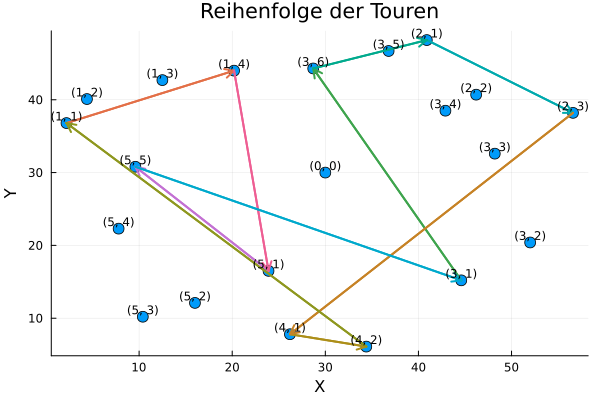

In [33]:
# 1) Knoten ⇒ (x,y)-Koordinaten mappen
node_coords = Dict{Tuple{Int,Int}, Tuple{Float64,Float64}}()
for row in eachrow(bus_line_stops)
  node = (row.bus_line_id, row.stop_ids)
  node_coords[node] = (row.stop_x, row.stop_y)
end
# Depot-Koordinate hinzufügen
node_coords[(0,0)] = (30, 30)

# 2) Aktivierte Kanten
edges = [(u,v) for (u,v) in A_set if value(x[(u,v)]) > 1e-6]

# 3) Basisscatter der Knoten zeichnen
xs = [coord[1] for coord in values(node_coords)]
ys = [coord[2] for coord in values(node_coords)]
p = scatter(xs, ys; marker=:circle, ms=6, xlabel="X", ylabel="Y", title="Reihenfolge der Touren", legend=false)

for (node, (xpt,ypt)) in node_coords
    annotate!(p, xpt, ypt, text(string(node), 8, :black, halign=:center, valign=:bottom))
end

for (u,v) in edges
    x1,y1 = node_coords[u]
    x2,y2 = node_coords[v]
    plot!(p, [x1, x2], [y1, y2]; arrow=:arrow, lw=2, label="")
end

display(p)

In [34]:
using Plots
plotlyjs()  # interaktives 3D-Backend

# 1) Knoten ⇒ (x,y)-Koordinaten mappen
node_coords = Dict{Tuple{Int,Int}, Tuple{Float64,Float64}}()
for row in eachrow(bus_line_stops)
    node = (row.bus_line_id, row.stop_ids)
    node_coords[node] = (row.stop_x, row.stop_y)
end
node_coords[(0,0)] = (30.0, 30.0)  # Depot-Koordinaten

# 2) Aktivierte Kanten (Tour)
edges = [(u,v) for (u,v) in A_set if value(x[(u,v)]) > 1e-6]

# 3) Zeitstempel (z-Koordinate)
node_time = Dict{Tuple{Int,Int}, Float64}()
time_val = 0.0
for (u, v) in edges
    if !haskey(node_time, u)
        node_time[u] = time_val
        time_val += 1.0
    end
    if !haskey(node_time, v)
        node_time[v] = time_val
        time_val += 1.0
    end
end
node_time[(0,0)] = -1.0  # Depot frühestmöglich

# 4) Knoten für 3D-Scatter
xs, ys, zs, labels = Float64[], Float64[], Float64[], String[]
for (node, (x, y)) in node_coords
    push!(xs, x)
    push!(ys, y)
    push!(zs, get(node_time, node, NaN))
    push!(labels, string(node))
end

# 5) Plot erstellen
p = scatter(xs, ys, zs;
    marker = (:circle, 6),
    xlabel = "X", ylabel = "Y", zlabel = "Zeit",
    title = "3D-Tourverlauf mit Zeitverlauf",
    legend = false,
    text = labels,
    textposition = :top_center
)

# 6) Tour-Kanten einzeichnen
for (u, v) in edges
    x1, y1 = node_coords[u]
    x2, y2 = node_coords[v]
    z1 = get(node_time, u, 0.0)
    z2 = get(node_time, v, 0.0)
    plot!([x1, x2], [y1, y2], [z1, z2]; lw = 2, arrow = :arrow, color = :blue, label = "")
end

# 7) Z-Achse durch das Depot als Linie darstellen
x_depot, y_depot = node_coords[(0,0)]
plot!([x_depot, x_depot], [y_depot, y_depot], [minimum(zs), maximum(zs)];
    lw = 3,
    linecolor = :black,
    linestyle = :dash,
    label = "Depot-Zeitachse"
)

# 8) Plot als HTML speichern im gleichen Ordner
save_path = joinpath(@__DIR__, "tour_3d_plot.html")
savefig(p, save_path)
println("✔️ 3D-Plot gespeichert unter: $save_path — öffne ihn im Browser.")


✔️ 3D-Plot gespeichert unter: /Users/alexanderklaus/Desktop/Masterthesis/Code/Models/tour_3d_plot.html — öffne ihn im Browser.


In [35]:
# Build adjacency list from A_set
adjacency = Dict{Tuple{Int, Int}, Vector{Tuple{Int, Int}}}()

for (i, j) in A_set
    if haskey(adjacency, i)
        push!(adjacency[i], j)
    else
        adjacency[i] = [j]
    end
end

# Tiefensuche vom Depot aus
function dfs(node, visited, adjacency)
    push!(visited, node)
    for neighbor in get(adjacency, node, [])
        if !(neighbor in visited)
            dfs(neighbor, visited, adjacency)
        end
    end
end

# DFS starten
visited = Set{Tuple{Int,Int}}()
dfs((0,0), visited, adjacency)

# Alle Startknoten ermitteln
start_nodes = [(l, first(line_stops_dict[l])) for l in keys(line_stops_dict)]

# Check: welche Startknoten nicht erreichbar?
unreachable = [node for node in start_nodes if !(node in visited)]

if isempty(unreachable)
    println("✅ Alle Startknoten sind vom Depot aus erreichbar!")

else
    println("❌ Nicht vom Depot erreichbare Startknoten:")
    println(unreachable)
end


✅ Alle Startknoten sind vom Depot aus erreichbar!
